This implementation utilizes PyTorch to construct the Deep Belief Network(DBN) model

# Import Libraries

In [104]:
%pip install torch numpy

In [105]:
# in case torch is not installed
%pip install torch scikit-learn

In [106]:
# in case pandas was not installed
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [107]:
# in case matplotlib was not installed
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [108]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [109]:
%pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [26]:
%pip install optuna

   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/2.1 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/2.1 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/2.1 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/2.1 MB ? eta -:--:--
   ---------- ----------------------------- 0.5/2.1 MB 364.6 kB/s eta 0:00:05
   ---------- ----------------------------- 0.5/2.1 MB 364.6 kB/s eta 0:00:05
   ---------- ----------------------------- 0.5/2.1 MB 364.6 kB/s eta 0:00:05
   ---------- ----------------------------- 0.5/2.1 MB 364.6 kB/s eta 0:00:0

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score
import matplotlib.pyplot as plt
import gc
from PIL import Image
from tqdm import tqdm


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "c:\Users\User\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\User\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\User\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\User\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py

# Configurations

In [3]:
# Setup the paths to train and test datasets
TRAIN_DIR = './global-wheat-detection/train/'
TEST_DIR = './global-wheat-detection/test/'
TRAIN_CSV_PATH = './global-wheat-detection/train.csv'
AUG_SAVE_DIR = './global-wheat-detection/augmented_images/'
SAVE_PATH = 'models/DBN/'
CHECKPOINT_DIR = 'models/DBN/checkpoints/'

# Model configuration
EPOCHS = 10
IMG_SIZE = 28
VISIBLE_UNITS = IMG_SIZE * IMG_SIZE
HIDDEN_UNITS_1 = 256  # Number of hidden units in the first RBM
HIDDEN_UNITS_2 = 128  # Number of hidden units in the second RBM
N_CLASSES = 2
BATCH_SIZE = 64  # Batch size for training
LEARNING_RATE = 0.01  # Learning rate for both pre-training and fine-tuning

# Create directories if they don't exist
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Loading

In [15]:
df = pd.read_csv('./df_augment.csv')
# df = pd.read_csv('./df_full.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242466 entries, 0 to 242465
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   image_id  242466 non-null  object 
 1   x         242466 non-null  float64
 2   y         242466 non-null  float64
 3   w         242466 non-null  float64
 4   h         242466 non-null  float64
 5   source    242466 non-null  object 
dtypes: float64(4), object(2)
memory usage: 11.1+ MB


Preprocessing

In [16]:
def group_bounding_boxes(group):
    bboxes = np.array(list(zip(group['x'], group['y'], group['w'], group['h'])), dtype=np.float32)
    return bboxes

# Apply the function to group bounding boxes by image_id
df_grouped = df.groupby('image_id').apply(lambda group: pd.Series({
    'bboxes': group_bounding_boxes(group),
    'source': group['source'].iloc[0]  # Keep the source or other necessary columns
})).reset_index()

# Check the resulting DataFrame
print(df_grouped.head())  # This should show 'image_id', 'bboxes', and 'source'

# Split the grouped data into training, validation, and test sets
train_df, test_df = train_test_split(df_grouped, test_size=0.4, random_state=42)
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42)

# Extract image paths
train_paths = [os.path.join(TRAIN_DIR, f'{image_id}.jpg') for image_id in train_df['image_id']]
val_paths = [os.path.join(TRAIN_DIR, f'{image_id}.jpg') for image_id in val_df['image_id']]
test_paths = [os.path.join(TRAIN_DIR, f'{image_id}.jpg') for image_id in test_df['image_id']]

# Extract bounding boxes
train_bboxes = train_df['bboxes'].tolist()
val_bboxes = val_df['bboxes'].tolist()
test_bboxes = test_df['bboxes'].tolist()

                image_id                                             bboxes  \
0              00333207f  [[0.0, 654.0, 37.0, 111.0], [0.0, 817.0, 135.0...   
1  00333207f_augmented_1  [[0.0, 259.0, 37.25467, 111.0], [0.0, 109.0, 1...   
2              005b0d8bb  [[765.0, 879.0, 116.0, 79.0], [84.0, 539.0, 15...   
3  005b0d8bb_augmented_1  [[0.0, 0.0, 24.0, 151.0], [260.0, 389.0, 138.0...   
4              006a994f7  [[437.0, 988.0, 98.0, 36.0], [309.0, 527.0, 11...   

      source  
0  arvalis_1  
1  arvalis_1  
2    usask_1  
3    usask_1  
4    inrae_1  


C:\Users\User\AppData\Local\Temp\ipykernel_1344\3198158563.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_grouped = df.groupby('image_id').apply(lambda group: pd.Series({


In [22]:
def load_image_and_bbox(image_id, bboxes, IMG_SIZE=IMG_SIZE):
    # Check if the image ID is for an augmented image
    if '_augmented_' in image_id:
        image_path = f'./global-wheat-detection/augmented_images/{image_id}.jpg'
    else:
        image_path = f'./global-wheat-detection/train/{image_id}.jpg'

    if not os.path.exists(image_path):
        print(f"Warning: File not found: {image_id}. Skipping this file.")
        return None, None

    # Load and process the image as before
    image = Image.open(image_path).convert('RGB')
    original_size = image.size  # Original size (width, height)
    image = image.resize((IMG_SIZE, IMG_SIZE))  # Resize the image to the desired size
    image = np.array(image, dtype=np.float32) / 255.0  # Normalize the image to [0, 1] range

    # Adjust bounding boxes according to the new image size
    scale_w = IMG_SIZE / original_size[0]
    scale_h = IMG_SIZE / original_size[1]
    bboxes[:, [0, 2]] *= scale_w  # Scale x and w
    bboxes[:, [1, 3]] *= scale_h  # Scale y and h

    return torch.tensor(image, dtype=torch.float32).permute(2, 0, 1), torch.tensor(bboxes, dtype=torch.float32)

def create_dataset(image_paths, bboxes, max_num_boxes):
    images = []
    targets = []

    for img_path, bbox in zip(image_paths, bboxes):
        image, bbox_tensor = load_image_and_bbox(img_path, bbox)

        if image is None or bbox_tensor is None:
            continue  # Skip if the file was not found or an error occurred

        # Pad bbox_tensor to max_num_boxes
        padded_bbox = torch.zeros((max_num_boxes, 4), dtype=torch.float32)
        padded_bbox[:bbox_tensor.size(0), :] = bbox_tensor

        images.append(image)
        targets.append(padded_bbox)

    # Ensure we have non-empty lists before stacking
    if len(images) == 0 or len(targets) == 0:
        raise ValueError("No images or targets were loaded. Check the paths and filenames.")

    images_tensor = torch.stack(images)
    bboxes_tensor = torch.stack(targets)

    return TensorDataset(images_tensor, bboxes_tensor)

def parse_dataframe(df_grouped):
    image_paths = []
    labels = []
    bboxes = []

    for _, group in df_grouped.iterrows():
        image_paths.append(group['image_id'])

        # bbox_list is already a NumPy array, no need to parse or evaluate
        bbox_list = group['bboxes']

        # Example condition: check if any bounding box width is greater than 0
        label = 1 if any(bbox[2] > 0 for bbox in bbox_list) else 0  # bbox[2] is the width 'w'
        labels.append(label)
        
        # No need to reconstruct the array, it's already structured as expected
        bboxes.append(bbox_list)
    
    return image_paths, labels, bboxes
    
def collate_fn(batch):
    images, bboxes = zip(*batch)
    
    # Stack images into a batch tensor
    images = torch.stack(images)
    
    # Find the max number of bounding boxes in the batch
    max_num_boxes = max(bbox.shape[0] for bbox in bboxes)
    
    # Pad the bounding boxes to the max number of boxes
    padded_bboxes = []
    for bbox in bboxes:
        padded_bbox = torch.zeros((max_num_boxes, 4), dtype=torch.float32)
        padded_bbox[:bbox.shape[0], :] = bbox
        padded_bboxes.append(padded_bbox)
    
    bboxes_tensor = torch.stack(padded_bboxes)
    
    return images, bboxes_tensor

# Load and preprocess the data
image_paths, labels, bboxes = parse_dataframe(df_grouped)

# Split the dataset
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.4, random_state=42)
test_paths, val_paths, test_labels, val_labels = train_test_split(test_paths, test_labels, test_size=0.5, random_state=42)

# Determine the maximum number of bounding boxes
max_num_boxes_in_dataset = max(len(bbox) for bbox in train_bboxes + val_bboxes + test_bboxes)
print(f"Maximum number of bounding boxes in dataset: {max_num_boxes_in_dataset}")

# Create PyTorch Datasets
# Now perform train-test split and create datasets
train_dataset = create_dataset(train_paths, train_bboxes, max_num_boxes=120)
val_dataset = create_dataset(val_paths, val_bboxes, max_num_boxes=120)
test_dataset = create_dataset(test_paths, test_bboxes, max_num_boxes=120)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Inspect the DataLoader
for images, targets in train_loader:
    labels = targets[:, :N_CLASSES]  # Replace N_CLASSES with the actual number of classes
    bboxes = targets[:, N_CLASSES:]  # The rest are bounding boxes

    print(f"Images batch shape: {images.shape}, Labels batch shape: {labels.shape}, BBoxes batch shape: {bboxes.shape}")
    break

for images, labels in val_loader:
    print(images.shape, labels.shape, len(val_loader))
    break

for images, labels in test_loader:
    print(images.shape, labels.shape, len(test_loader))
    break

Maximum number of bounding boxes in dataset: 116
Images batch shape: torch.Size([64, 3, 28, 28]), Labels batch shape: torch.Size([64, 2, 4]), BBoxes batch shape: torch.Size([64, 118, 4])
torch.Size([64, 3, 28, 28]) torch.Size([64, 120, 4]) 22
torch.Size([64, 3, 28, 28]) torch.Size([64, 120, 4]) 22


# Model Building

In [23]:
def plot_metrics(history):
    epochs = range(1, len(history['loss']) + 1)

    # Plot loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['loss'], 'r-', label='Training Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['accuracy'], 'b-', label='Training Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [24]:
# Precision Metric
def precision_metric(y_true, y_pred):
    return precision_score(y_true, y_pred, average='weighted')

# Recall Metric
def recall_metric(y_true, y_pred):
    return recall_score(y_true, y_pred, average='weighted')

# F1 Score Metric
def f1_metric(y_true, y_pred):
    return f1_score(y_true, y_pred, average='weighted')

# Intersection over Union (IoU) Metric
def iou_metric(y_true, y_pred):
    return jaccard_score(y_true, y_pred, average='weighted')

In [61]:
class RBM(nn.Module):
    def __init__(self, visible_units, hidden_units, k=1):
        super(RBM, self).__init__()
        self.visible_units = visible_units  # This should match the input size (e.g., 2352 for 28x28x3 images)
        self.hidden_units = hidden_units  # Number of hidden units (e.g., 256)
        self.k = k  # Number of Gibbs sampling steps

        # Initialize weights and biases with correct dimensions
        self.W = nn.Parameter(torch.randn(hidden_units, visible_units) * 0.01)
        self.h_bias = nn.Parameter(torch.zeros(hidden_units))  # Hidden bias
        self.v_bias = nn.Parameter(torch.zeros(visible_units))  # Visible bias

    def sample_h(self, v):
        # Compute probability of hidden unit given visible units
        h_prob = torch.sigmoid(F.linear(v, self.W, self.h_bias))
        return h_prob, torch.bernoulli(h_prob)

    def sample_v(self, h):
        # Compute probability of visible unit given hidden units
        v_prob = torch.sigmoid(F.linear(h, self.W.t(), self.v_bias))
        return v_prob, torch.bernoulli(v_prob)

    def forward(self, v):
        # Perform k steps of Gibbs sampling
        h_prob, h_sample = self.sample_h(v)
        for _ in range(self.k):
            v_prob, v_sample = self.sample_v(h_sample)
            h_prob, h_sample = self.sample_h(v_sample)
        return v_sample

In [26]:
class DBN(nn.Module):
    def __init__(self, rbm_layers, n_classes):
        super(DBN, self).__init__()
        self.rbm_layers = nn.ModuleList(rbm_layers)
        self.n_classes = n_classes
        self.classifier = nn.Linear(rbm_layers[-1].hidden_units, n_classes)
    
    def forward(self, x):
        # Pass through each RBM layer
        for rbm in self.rbm_layers:
            x, _ = rbm.sample_h(x)  # Get the hidden layer output
        # Pass through the final classifier layer
        x = self.classifier(x)
        return x

# DBN_1

In [62]:
class DBNModel(nn.Module):
    def __init__(self, visible_units, hidden_units_1, hidden_units_2, n_classes, num_boxes=10):
        super(DBNModel, self).__init__()
        self.rbm1 = RBM(visible_units, hidden_units_1)
        self.rbm2 = RBM(hidden_units_1, hidden_units_2)
        
        self.fc_class = nn.Linear(in_features=hidden_units_2, out_features=n_classes, bias=True)
        self.fc_bbox = nn.Linear(in_features=hidden_units_2, out_features=num_boxes * 4, bias=True)
        
        self.criterion_class = nn.CrossEntropyLoss()
        self.criterion_bbox = nn.SmoothL1Loss()

        self.num_boxes = num_boxes  # Store the number of bounding boxes

    def forward(self, x):
        # Flatten input if it's an image
        batch_size = x.size(0)
        x = x.view(batch_size, -1)  # Flatten to [batch_size, visible_units]

        x = self.rbm1(x)
        x = self.rbm2(x)
        
        class_output = self.fc_class(x)
        bbox_output = self.fc_bbox(x)
        
        bbox_output = bbox_output.view(-1, self.num_boxes, 4)
        
        return class_output, bbox_output

    def compile_model(self, learning_rate=0.01):
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        self.criterion_class = nn.CrossEntropyLoss()  # For class labels
        self.criterion_bbox = nn.SmoothL1Loss()  # For bounding boxes

    def train_model(self, train_loader, epochs=10, checkpoint_dir=None):
        history = {'loss': [], 'accuracy': []}
        best_loss = float('inf')

        for epoch in range(epochs):
            self.train()
            total_loss = 0
            correct = 0
            for data, target in train_loader:
                self.optimizer.zero_grad()

                # Split target into labels and bounding boxes
                labels = target[:, 0].long()  # Ensure labels is 1D

                # Forward pass through the model
                class_output, bbox_output = self.forward(data)

                # Get batch size from bbox_output
                batch_size = bbox_output.size(0)  # Should be 64

                # Calculate the actual number of bounding boxes from the model
                num_boxes = self.num_boxes  # Use the num_boxes set in the model

                # Ensure `bboxes` has the correct shape
                bboxes = target[:, 1:].reshape(batch_size, num_boxes, 4)

                # Print shapes for debugging
                print("bbox_output shape:", bbox_output.shape)
                print("bboxes shape:", bboxes.shape)

                # Compute losses
                loss_class = self.criterion_class(class_output, labels)
                loss_bbox = self.criterion_bbox(bbox_output, bboxes)
                total_loss = loss_class + loss_bbox

                # Backward pass and optimization
                total_loss.backward()
                self.optimizer.step()

                total_loss += total_loss.item()
                pred = class_output.argmax(dim=1, keepdim=True)
                correct += pred.eq(labels.view_as(pred)).sum().item()

            avg_loss = total_loss / len(train_loader)
            accuracy = correct / len(train_loader.dataset)
            history['loss'].append(avg_loss)
            history['accuracy'].append(accuracy)
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

            # Save checkpoint if this is the best model so far
            if checkpoint_dir and avg_loss < best_loss:
                best_loss = avg_loss
                checkpoint_path = os.path.join(checkpoint_dir, f'epoch_{epoch + 1}_loss_{avg_loss:.4f}.pth')
                torch.save(self.state_dict(), checkpoint_path)
                print(f"Checkpoint saved: {checkpoint_path}")

        return history

    def evaluate(self, test_loader):
        self.eval()
        total_loss = 0
        correct = 0
        y_true = []
        y_pred = []

        with torch.no_grad():
            for data, target in test_loader:
                labels = target[:, 0].long()  # The first element is the class label
                bboxes = target[:, 1:].view(-1, 4)  # The rest are bounding boxes

                class_output, bbox_output = self.forward(data)
                loss_class = self.criterion_class(class_output, labels)
                loss_bbox = self.criterion_bbox(bbox_output, bboxes)
                total_loss += (loss_class + loss_bbox).item()
                pred = class_output.argmax(dim=1, keepdim=True)
                correct += pred.eq(labels.view_as(pred)).sum().item()

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(pred.cpu().numpy())

        avg_loss = total_loss / len(test_loader)
        accuracy = correct / len(test_loader.dataset)

        print(f'Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')
        return {
            'loss': avg_loss,
            'accuracy': accuracy,
            'y_true': y_true,
            'y_pred': y_pred,
        }

# Initialize the DBN model with the correct parameters
visible_units = 28 * 28 * 3  # For a 28x28 image with 3 channels (RGB)
hidden_units_1 = 256
hidden_units_2 = 128

dbn_model = DBNModel(visible_units=visible_units, hidden_units_1=hidden_units_1, hidden_units_2=hidden_units_2, n_classes=2, num_boxes=10)

# Compile the model
LEARNING_RATE = 0.01
dbn_model.compile_model(learning_rate=LEARNING_RATE)

# Print model summary (not as straightforward in PyTorch, but showing the structure)
print(dbn_model)

DBNModel(
  (rbm1): RBM()
  (rbm2): RBM()
  (fc_class): Linear(in_features=128, out_features=2, bias=True)
  (fc_bbox): Linear(in_features=128, out_features=40, bias=True)
  (criterion_class): CrossEntropyLoss()
  (criterion_bbox): SmoothL1Loss()
)


In [63]:
history = dbn_model.train_model(train_loader, epochs=EPOCHS, checkpoint_dir=CHECKPOINT_DIR)

# Evaluate the DBN model on the test set
test_metrics = dbn_model.evaluate(test_loader)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x2352 and 256x128)

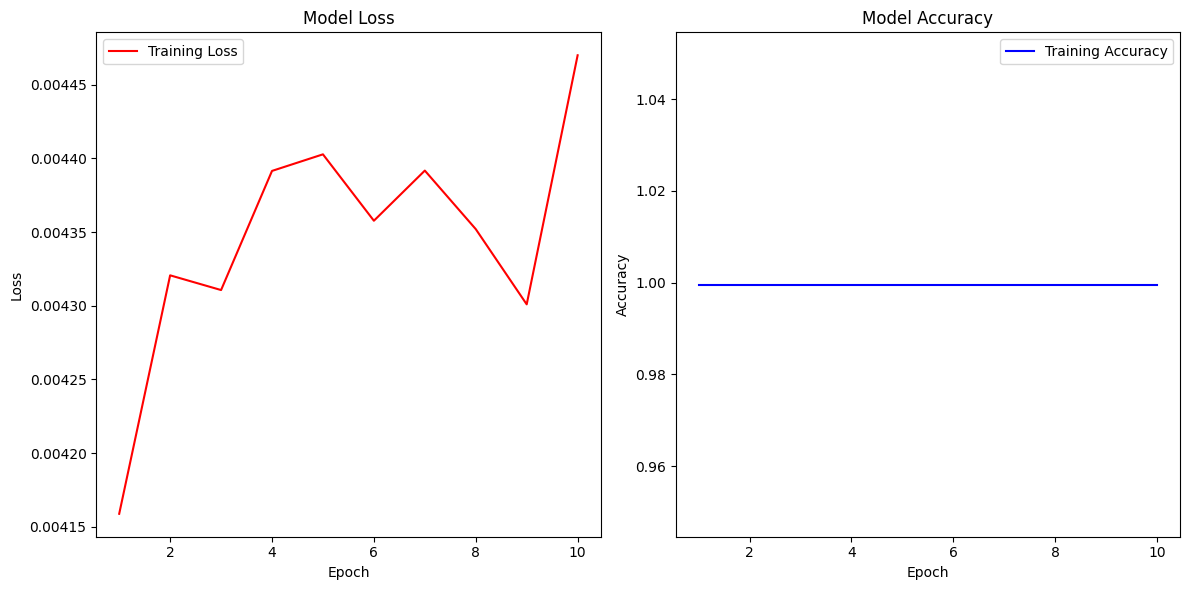

In [19]:
# Plot the training metrics
plot_metrics(history)

In [20]:
# Save the entire DBN model
dbn_model.save(SAVE_PATH + 'dbn_model.pth')

In [21]:
# Load the DBN model from a file
# dbn_model.load(SAVE_PATH + 'dbn_model.pth')

# Perform garbage collection
gc.collect()

6755

# DBN_2

The hidden units in the RBM layers are increased to 512 and 256, respectively, which makes this model potentially more capable of capturing complex features but at the cost of increased computational requirements.

In [ ]:
# Define the DBN model with more hidden units
dbn_model_2 = DBNModel(visible_units=VISIBLE_UNITS, 
                       hidden_units_1=512,  # Increased from 256 to 512
                       hidden_units_2=256,  # Increased from 128 to 256
                       n_classes=N_CLASSES)

# Compile the model
dbn_model_2.compile_model(learning_rate=LEARNING_RATE)

# Print model summary
print(dbn_model_2.model)

In [ ]:
# Train the model
history_2 = dbn_model_2.train(train_loader, epochs=EPOCHS, checkpoint_dir=CHECKPOINT_DIR)

# Evaluate the model on the test set
test_metrics_2 = dbn_model_2.evaluate(test_loader)

In [ ]:
# Plot the training metrics
plot_metrics(history_2)

In [ ]:
# Save the model
dbn_model_2.save(SAVE_PATH + 'dbn_model_2.pth')

In [ ]:
# Load the model (if needed)
# dbn_model_2.load(SAVE_PATH + 'dbn_model_2.pth')
gc.collect()

# DBN_3

A third RBM layer with 64 hidden units is added, making the network deeper. This modification allows the DBN to potentially learn even more abstract features but also requires careful tuning and more data to avoid overfitting.

In [ ]:
# Define the DBN model with an additional RBM layer
class DBNModelExtended(DBNModel):
    def build_model(self):
        # Initialize RBMs with an additional layer
        rbm1 = RBM(visible_units=self.visible_units, hidden_units=self.hidden_units_1)
        rbm2 = RBM(visible_units=self.hidden_units_1, hidden_units=self.hidden_units_2)
        rbm3 = RBM(visible_units=self.hidden_units_2, hidden_units=64)  # New additional RBM layer
        
        # Stack RBMs to form a DBN
        dbn = DBN(rbm_layers=[rbm1, rbm2, rbm3], n_classes=self.n_classes)
        return dbn

# Initialize the DBN model
dbn_model_3 = DBNModelExtended(visible_units=VISIBLE_UNITS, 
                               hidden_units_1=HIDDEN_UNITS_1, 
                               hidden_units_2=HIDDEN_UNITS_2, 
                               n_classes=N_CLASSES)

# Compile the model
dbn_model_3.compile_model(learning_rate=LEARNING_RATE)

# Print model summary
print(dbn_model_3.model)

In [ ]:
# Train the model
history_3 = dbn_model_3.train(train_loader, epochs=EPOCHS, checkpoint_dir=CHECKPOINT_DIR)

# Evaluate the model on the test set
test_metrics_3 = dbn_model_3.evaluate(test_loader)

In [ ]:
# Plot the training metrics
plot_metrics(history_3)

In [ ]:
# Save the model
dbn_model_3.save(SAVE_PATH + 'dbn_model_3.pth')

In [ ]:
# Load the model (if needed)
# dbn_model_3.load(SAVE_PATH + 'dbn_model_3.pth')
gc.collect()

# Saving History

[I just did for first DBN model]

In [23]:
import pickle

# Save the training history for the first DBN model
with open('dbn_training_history_1.pkl', 'wb') as file:
    pickle.dump(history, file)

# Save the training history for the second DBN model
#with open('dbn_training_history_2.pkl', 'wb') as file:
#    pickle.dump(history_2, file)

# Save the training history for the third DBN model
#with open('dbn_training_history_3.pkl', 'wb') as file:
#    pickle.dump(history_3, file)

In [24]:
# Load the training history for the first DBN model
with open('dbn_training_history_1.pkl', 'rb') as file:
    loaded_history_1 = pickle.load(file)

# Initialize the model again if needed
dbn_model = DBNModel(visible_units=VISIBLE_UNITS, 
                     hidden_units_1=HIDDEN_UNITS_1, 
                     hidden_units_2=HIDDEN_UNITS_2, 
                     n_classes=N_CLASSES)

# Compile the model
dbn_model.compile_model(learning_rate=LEARNING_RATE)

# Train the model for zero epochs to create an empty history object
empty_history_1 = dbn_model.train(train_loader, epochs=0, checkpoint_dir=None)

# Set the loaded history to the empty history object
empty_history_1 = loaded_history_1

# Now empty_history_1 contains the loaded history
plot_metrics(empty_history_1)

TypeError: Module.train() got an unexpected keyword argument 'epochs'

# Hyperparameter Tuning (For DBN_1)

In [36]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from optuna import Trial

class DBNHyperModel:
    def __init__(self, visible_units, n_classes):
        self.visible_units = visible_units
        self.n_classes = n_classes

    def build(self, trial: Trial):
        # Sample hyperparameters
        hidden_units_1 = trial.suggest_int('hidden_units_1', 128, 512, step=64)
        hidden_units_2 = trial.suggest_int('hidden_units_2', 64, 256, step=64)
        learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)

        # Build the DBN
        rbm1 = RBM(visible_units=self.visible_units, hidden_units=hidden_units_1)
        rbm2 = RBM(visible_units=hidden_units_1, hidden_units=hidden_units_2)

        dbn = DBN(rbm_layers=[rbm1, rbm2], n_classes=self.n_classes)
        optimizer = optim.Adam(dbn.parameters(), lr=learning_rate)
        
        return dbn, optimizer

    def objective(self, trial: Trial):
        # Build the model
        model, optimizer = self.build(trial)
        criterion = nn.CrossEntropyLoss()

        # Train the model
        model.train()
        for epoch in range(EPOCHS):
            total_loss = 0
            for data, target in train_loader:
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)

            # Validation
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for data, target in val_loader:
                    output = model(data)
                    loss = criterion(output, target)
                    val_loss += loss.item()
            val_loss /= len(val_loader)

            # Report intermediate objective value
            trial.report(val_loss, epoch)

            # Handle pruning (optional)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

        return val_loss

# Initialize the hypermodel
hypermodel = DBNHyperModel(visible_units=VISIBLE_UNITS, n_classes=N_CLASSES)

# Create an Optuna study
study = optuna.create_study(direction='minimize')

[I 2024-09-03 09:39:20,229] A new study created in memory with name: no-name-9ea89b7b-d5af-43d5-bef8-a6e727dba4b8


In [42]:
# Define the objective function
def objective(trial):
    # Suggest hyperparameters for tuning
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    hidden_units_1 = trial.suggest_int('hidden_units_1', 64, 256)
    hidden_units_2 = trial.suggest_int('hidden_units_2', 32, 128)

    # Create the model with the suggested hyperparameters
    model = DBNModel(visible_units=784, hidden_units_1=hidden_units_1, hidden_units_2=hidden_units_2, n_classes=2)
    model.compile_model(learning_rate=learning_rate)

    # Train the model (you may use your existing train_loader and val_loader)
    history_1 = model.train_model(train_loader, epochs=EPOCHS)

    # Evaluate the model on the validation set
    val_metrics = model.evaluate(val_loader)

    # The objective is to maximize accuracy, so return the validation accuracy
    return val_metrics['accuracy']

# Create a study object
study = optuna.create_study(direction='maximize')

# Run the optimization
study.optimize(objective, n_trials=100)

# Retrieve the best hyperparameters
best_hyperparameters = study.best_trial

# Extract the best learning rate if it was tuned
best_learning_rate = best_hyperparameters.params.get('learning_rate', 0.001)  # Default to 0.001 if not tuned

# Print the best learning rate to verify
print(f"Best learning rate: {best_learning_rate}")
print(best_hyperparameters.params)

# Build the model using the best hyperparameters
best_model, best_optimizer = hypermodel.build(best_hyperparameters)

# Ensure the optimizer uses the best learning rate
for param_group in best_optimizer.param_groups:
    param_group['lr'] = best_learning_rate

# Example of a learning rate scheduler and early stopping in PyTorch
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Learning rate scheduler
scheduler = ReduceLROnPlateau(best_optimizer, mode='min', factor=0.2, patience=3, min_lr=1e-5)

# Early stopping parameters
early_stopping_patience = 5
best_val_loss = float('inf')
patience_counter = 0

history_best = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

for epoch in range(EPOCHS):
    best_model.train()
    total_loss = 0
    correct = 0
    
    # Training loop
    for data, target in train_loader:
        best_optimizer.zero_grad()
        output = best_model(data)
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        best_optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    
    # Validation loop
    best_model.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            output = best_model(data)
            loss = nn.CrossEntropyLoss()(output, target)
            val_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            val_correct += pred.eq(target.view_as(pred)).sum().item()
    
    # Compute average losses
    avg_train_loss = total_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_accuracy = correct / len(train_loader.dataset)
    val_accuracy = val_correct / len(val_loader.dataset)
    
    # Append to history
    history_best['loss'].append(avg_train_loss)
    history_best['val_loss'].append(avg_val_loss)
    history_best['accuracy'].append(train_accuracy)
    history_best['val_accuracy'].append(val_accuracy)
    
    # Print epoch summary
    print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')
    
    # Early stopping and learning rate scheduling
    scheduler.step(avg_val_loss)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(best_model.state_dict(), os.path.join(CHECKPOINT_DIR, 'best_dbn_model.pth'))  # Save the best model
    else:
        patience_counter += 1
    
    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered.")
        break

# Load the best model
best_model.load_state_dict(torch.load(os.path.join(CHECKPOINT_DIR, 'best_dbn_model.pth')))
best_model.eval()

# Evaluate the best model on the test set
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        output = best_model(data)
        loss = nn.CrossEntropyLoss()(output, target)
        test_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)
test_accuracy = correct / len(test_loader.dataset)

print(f'Best model testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.4f}')

[I 2024-09-03 09:50:05,013] A new study created in memory with name: no-name-723a551e-3a67-4a60-8ea9-aaa868aca995


Epoch 1/10, Loss: 0.0689, Accuracy: 0.9876
Epoch 2/10, Loss: 0.0065, Accuracy: 0.9996
Epoch 3/10, Loss: 0.0039, Accuracy: 0.9996
Epoch 4/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 5/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 6/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 7/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 8/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 9/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 10/10, Loss: 0.0035, Accuracy: 0.9996


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-09-03 09:51:31,064] Trial 0 finished with value: 0.9996700622757455 and parameters: {'learning_rate': 9.878972647192918e-05, 'hidden_units_1': 253, 'hidden_units_2': 42}. Best is trial 0 with value: 0.9996700622757455.


Test Loss: 0.0029, Accuracy: 0.9997, Precision: 0.9993, Recall: 0.9997, F1-Score: 0.9995, IoU: 0.9993
Epoch 1/10, Loss: 0.0041, Accuracy: 0.9996
Epoch 2/10, Loss: 0.0037, Accuracy: 0.9996
Epoch 3/10, Loss: 0.0037, Accuracy: 0.9996
Epoch 4/10, Loss: 0.0037, Accuracy: 0.9996
Epoch 5/10, Loss: 0.0038, Accuracy: 0.9996
Epoch 6/10, Loss: 0.0038, Accuracy: 0.9996
Epoch 7/10, Loss: 0.0040, Accuracy: 0.9996
Epoch 8/10, Loss: 0.0037, Accuracy: 0.9996
Epoch 9/10, Loss: 0.0037, Accuracy: 0.9996
Epoch 10/10, Loss: 0.0036, Accuracy: 0.9996


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-09-03 09:53:20,823] Trial 1 finished with value: 0.9996700622757455 and parameters: {'learning_rate': 0.003917501016697021, 'hidden_units_1': 253, 'hidden_units_2': 112}. Best is trial 0 with value: 0.9996700622757455.


Test Loss: 0.0030, Accuracy: 0.9997, Precision: 0.9993, Recall: 0.9997, F1-Score: 0.9995, IoU: 0.9993
Epoch 1/10, Loss: 0.0045, Accuracy: 0.9996
Epoch 2/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 3/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 4/10, Loss: 0.0034, Accuracy: 0.9996
Epoch 5/10, Loss: 0.0032, Accuracy: 0.9996
Epoch 6/10, Loss: 0.0032, Accuracy: 0.9996
Epoch 7/10, Loss: 0.0031, Accuracy: 0.9996
Epoch 8/10, Loss: 0.0032, Accuracy: 0.9996
Epoch 9/10, Loss: 0.0031, Accuracy: 0.9996
Epoch 10/10, Loss: 0.0031, Accuracy: 0.9996


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-09-03 09:54:56,543] Trial 2 finished with value: 0.9996700622757455 and parameters: {'learning_rate': 0.0006517151787620411, 'hidden_units_1': 180, 'hidden_units_2': 122}. Best is trial 0 with value: 0.9996700622757455.


Test Loss: 0.0026, Accuracy: 0.9997, Precision: 0.9993, Recall: 0.9997, F1-Score: 0.9995, IoU: 0.9993
Epoch 1/10, Loss: 0.0116, Accuracy: 0.9974
Epoch 2/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 3/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 4/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 5/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 6/10, Loss: 0.0034, Accuracy: 0.9996
Epoch 7/10, Loss: 0.0033, Accuracy: 0.9996
Epoch 8/10, Loss: 0.0032, Accuracy: 0.9996
Epoch 9/10, Loss: 0.0031, Accuracy: 0.9996
Epoch 10/10, Loss: 0.0031, Accuracy: 0.9996


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-09-03 09:56:25,054] Trial 3 finished with value: 0.9996700622757455 and parameters: {'learning_rate': 0.00021508185937587108, 'hidden_units_1': 212, 'hidden_units_2': 127}. Best is trial 0 with value: 0.9996700622757455.


Test Loss: 0.0026, Accuracy: 0.9997, Precision: 0.9993, Recall: 0.9997, F1-Score: 0.9995, IoU: 0.9993
Epoch 1/10, Loss: 0.0047, Accuracy: 0.9996
Epoch 2/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 3/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 4/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 5/10, Loss: 0.0033, Accuracy: 0.9996
Epoch 6/10, Loss: 0.0033, Accuracy: 0.9996
Epoch 7/10, Loss: 0.0032, Accuracy: 0.9996
Epoch 8/10, Loss: 0.0032, Accuracy: 0.9996
Epoch 9/10, Loss: 0.0031, Accuracy: 0.9996
Epoch 10/10, Loss: 0.0030, Accuracy: 0.9996


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-09-03 09:57:35,934] Trial 4 finished with value: 0.9996700622757455 and parameters: {'learning_rate': 0.0008040224411322317, 'hidden_units_1': 193, 'hidden_units_2': 110}. Best is trial 0 with value: 0.9996700622757455.


Test Loss: 0.0025, Accuracy: 0.9997, Precision: 0.9993, Recall: 0.9997, F1-Score: 0.9995, IoU: 0.9993
Epoch 1/10, Loss: 0.0054, Accuracy: 0.9992
Epoch 2/10, Loss: 0.0061, Accuracy: 0.9996
Epoch 3/10, Loss: 0.0072, Accuracy: 0.9996
Epoch 4/10, Loss: 0.0066, Accuracy: 0.9996
Epoch 5/10, Loss: 0.0064, Accuracy: 0.9996
Epoch 6/10, Loss: 0.0068, Accuracy: 0.9996
Epoch 7/10, Loss: 0.0075, Accuracy: 0.9996
Epoch 8/10, Loss: 0.0069, Accuracy: 0.9996
Epoch 9/10, Loss: 0.0066, Accuracy: 0.9996
Epoch 10/10, Loss: 0.0068, Accuracy: 0.9996


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-09-03 09:59:11,375] Trial 5 finished with value: 0.9996700622757455 and parameters: {'learning_rate': 0.06174435285619339, 'hidden_units_1': 161, 'hidden_units_2': 67}. Best is trial 0 with value: 0.9996700622757455.


Test Loss: 0.0046, Accuracy: 0.9997, Precision: 0.9993, Recall: 0.9997, F1-Score: 0.9995, IoU: 0.9993
Epoch 1/10, Loss: 0.0041, Accuracy: 0.9996
Epoch 2/10, Loss: 0.0039, Accuracy: 0.9996
Epoch 3/10, Loss: 0.0039, Accuracy: 0.9996
Epoch 4/10, Loss: 0.0039, Accuracy: 0.9996
Epoch 5/10, Loss: 0.0039, Accuracy: 0.9996
Epoch 6/10, Loss: 0.0039, Accuracy: 0.9996
Epoch 7/10, Loss: 0.0038, Accuracy: 0.9996
Epoch 8/10, Loss: 0.0040, Accuracy: 0.9996
Epoch 9/10, Loss: 0.0038, Accuracy: 0.9996
Epoch 10/10, Loss: 0.0036, Accuracy: 0.9996


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-09-03 09:59:53,601] Trial 6 finished with value: 0.9996700622757455 and parameters: {'learning_rate': 0.007210993240990051, 'hidden_units_1': 64, 'hidden_units_2': 113}. Best is trial 0 with value: 0.9996700622757455.


Test Loss: 0.0031, Accuracy: 0.9997, Precision: 0.9993, Recall: 0.9997, F1-Score: 0.9995, IoU: 0.9993
Epoch 1/10, Loss: 0.0123, Accuracy: 0.9996
Epoch 2/10, Loss: 0.0252, Accuracy: 0.9996
Epoch 3/10, Loss: 0.0254, Accuracy: 0.9996
Epoch 4/10, Loss: 0.0196, Accuracy: 0.9996
Epoch 5/10, Loss: 0.0310, Accuracy: 0.9996
Epoch 6/10, Loss: 0.0171, Accuracy: 0.9996
Epoch 7/10, Loss: 0.0204, Accuracy: 0.9996
Epoch 8/10, Loss: 0.0224, Accuracy: 0.9996
Epoch 9/10, Loss: 0.0225, Accuracy: 0.9996
Epoch 10/10, Loss: 0.0390, Accuracy: 0.9992


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-09-03 10:00:58,628] Trial 7 finished with value: 0.9996700622757455 and parameters: {'learning_rate': 0.0805728504542829, 'hidden_units_1': 79, 'hidden_units_2': 118}. Best is trial 0 with value: 0.9996700622757455.


Test Loss: 0.0030, Accuracy: 0.9997, Precision: 0.9993, Recall: 0.9997, F1-Score: 0.9995, IoU: 0.9993
Epoch 1/10, Loss: 0.0043, Accuracy: 0.9996
Epoch 2/10, Loss: 0.0036, Accuracy: 0.9996
Epoch 3/10, Loss: 0.0036, Accuracy: 0.9996
Epoch 4/10, Loss: 0.0036, Accuracy: 0.9996
Epoch 5/10, Loss: 0.0036, Accuracy: 0.9996
Epoch 6/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 7/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 8/10, Loss: 0.0034, Accuracy: 0.9996
Epoch 9/10, Loss: 0.0034, Accuracy: 0.9996
Epoch 10/10, Loss: 0.0035, Accuracy: 0.9996


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-09-03 10:01:54,177] Trial 8 finished with value: 0.9996700622757455 and parameters: {'learning_rate': 0.0023371786016238784, 'hidden_units_1': 71, 'hidden_units_2': 56}. Best is trial 0 with value: 0.9996700622757455.


Test Loss: 0.0027, Accuracy: 0.9997, Precision: 0.9993, Recall: 0.9997, F1-Score: 0.9995, IoU: 0.9993
Epoch 1/10, Loss: 0.0040, Accuracy: 0.9996
Epoch 2/10, Loss: 0.0038, Accuracy: 0.9996
Epoch 3/10, Loss: 0.0037, Accuracy: 0.9996
Epoch 4/10, Loss: 0.0039, Accuracy: 0.9996
Epoch 5/10, Loss: 0.0038, Accuracy: 0.9996
Epoch 6/10, Loss: 0.0039, Accuracy: 0.9996
Epoch 7/10, Loss: 0.0038, Accuracy: 0.9996
Epoch 8/10, Loss: 0.0039, Accuracy: 0.9996
Epoch 9/10, Loss: 0.0039, Accuracy: 0.9996
Epoch 10/10, Loss: 0.0036, Accuracy: 0.9996


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-09-03 10:03:14,765] Trial 9 finished with value: 0.9996700622757455 and parameters: {'learning_rate': 0.005260938656803787, 'hidden_units_1': 173, 'hidden_units_2': 109}. Best is trial 0 with value: 0.9996700622757455.


Test Loss: 0.0031, Accuracy: 0.9997, Precision: 0.9993, Recall: 0.9997, F1-Score: 0.9995, IoU: 0.9993
Epoch 1/10, Loss: 0.1034, Accuracy: 0.9996
Epoch 2/10, Loss: 0.0165, Accuracy: 0.9996
Epoch 3/10, Loss: 0.0070, Accuracy: 0.9996
Epoch 4/10, Loss: 0.0044, Accuracy: 0.9996
Epoch 5/10, Loss: 0.0037, Accuracy: 0.9996
Epoch 6/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 7/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 8/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 9/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 10/10, Loss: 0.0035, Accuracy: 0.9996


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-09-03 10:04:13,647] Trial 10 finished with value: 0.9996700622757455 and parameters: {'learning_rate': 2.3309743071295687e-05, 'hidden_units_1': 121, 'hidden_units_2': 34}. Best is trial 0 with value: 0.9996700622757455.


Test Loss: 0.0030, Accuracy: 0.9997, Precision: 0.9993, Recall: 0.9997, F1-Score: 0.9995, IoU: 0.9993
Epoch 1/10, Loss: 0.0393, Accuracy: 0.9996
Epoch 2/10, Loss: 0.0048, Accuracy: 0.9996
Epoch 3/10, Loss: 0.0036, Accuracy: 0.9996
Epoch 4/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 5/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 6/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 7/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 8/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 9/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 10/10, Loss: 0.0034, Accuracy: 0.9996


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-09-03 10:05:51,695] Trial 11 finished with value: 0.9996700622757455 and parameters: {'learning_rate': 3.63166235297209e-05, 'hidden_units_1': 255, 'hidden_units_2': 89}. Best is trial 0 with value: 0.9996700622757455.


Test Loss: 0.0030, Accuracy: 0.9997, Precision: 0.9993, Recall: 0.9997, F1-Score: 0.9995, IoU: 0.9993
Epoch 1/10, Loss: 0.0246, Accuracy: 0.9928
Epoch 2/10, Loss: 0.0036, Accuracy: 0.9996
Epoch 3/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 4/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 5/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 6/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 7/10, Loss: 0.0034, Accuracy: 0.9996
Epoch 8/10, Loss: 0.0033, Accuracy: 0.9996
Epoch 9/10, Loss: 0.0032, Accuracy: 0.9996
Epoch 10/10, Loss: 0.0032, Accuracy: 0.9996


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-09-03 10:07:25,498] Trial 12 finished with value: 0.9996700622757455 and parameters: {'learning_rate': 0.0001619532166098359, 'hidden_units_1': 244, 'hidden_units_2': 90}. Best is trial 0 with value: 0.9996700622757455.


Test Loss: 0.0027, Accuracy: 0.9997, Precision: 0.9993, Recall: 0.9997, F1-Score: 0.9995, IoU: 0.9993
Epoch 1/10, Loss: 0.0422, Accuracy: 0.9996
Epoch 2/10, Loss: 0.0056, Accuracy: 0.9996
Epoch 3/10, Loss: 0.0038, Accuracy: 0.9996
Epoch 4/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 5/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 6/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 7/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 8/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 9/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 10/10, Loss: 0.0035, Accuracy: 0.9996


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-09-03 10:09:07,124] Trial 13 finished with value: 0.9996700622757455 and parameters: {'learning_rate': 9.622734519115696e-05, 'hidden_units_1': 217, 'hidden_units_2': 34}. Best is trial 0 with value: 0.9996700622757455.


Test Loss: 0.0029, Accuracy: 0.9997, Precision: 0.9993, Recall: 0.9997, F1-Score: 0.9995, IoU: 0.9993
Epoch 1/10, Loss: 0.1598, Accuracy: 0.9996
Epoch 2/10, Loss: 0.0289, Accuracy: 0.9996
Epoch 3/10, Loss: 0.0129, Accuracy: 0.9996
Epoch 4/10, Loss: 0.0069, Accuracy: 0.9996
Epoch 5/10, Loss: 0.0047, Accuracy: 0.9996
Epoch 6/10, Loss: 0.0039, Accuracy: 0.9996
Epoch 7/10, Loss: 0.0036, Accuracy: 0.9996
Epoch 8/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 9/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 10/10, Loss: 0.0035, Accuracy: 0.9996


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-09-03 10:10:27,636] Trial 14 finished with value: 0.9996700622757455 and parameters: {'learning_rate': 1.102208317347008e-05, 'hidden_units_1': 232, 'hidden_units_2': 55}. Best is trial 0 with value: 0.9996700622757455.


Test Loss: 0.0030, Accuracy: 0.9997, Precision: 0.9993, Recall: 0.9997, F1-Score: 0.9995, IoU: 0.9993
Epoch 1/10, Loss: 0.0043, Accuracy: 0.9992
Epoch 2/10, Loss: 0.0041, Accuracy: 0.9996
Epoch 3/10, Loss: 0.0043, Accuracy: 0.9996
Epoch 4/10, Loss: 0.0043, Accuracy: 0.9996
Epoch 5/10, Loss: 0.0043, Accuracy: 0.9996
Epoch 6/10, Loss: 0.0043, Accuracy: 0.9996
Epoch 7/10, Loss: 0.0044, Accuracy: 0.9996
Epoch 8/10, Loss: 0.0043, Accuracy: 0.9996
Epoch 9/10, Loss: 0.0044, Accuracy: 0.9996
Epoch 10/10, Loss: 0.0043, Accuracy: 0.9996


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-09-03 10:11:54,521] Trial 15 finished with value: 0.9996700622757455 and parameters: {'learning_rate': 0.013622459919849759, 'hidden_units_1': 138, 'hidden_units_2': 98}. Best is trial 0 with value: 0.9996700622757455.


Test Loss: 0.0036, Accuracy: 0.9997, Precision: 0.9993, Recall: 0.9997, F1-Score: 0.9995, IoU: 0.9993
Epoch 1/10, Loss: 0.0083, Accuracy: 0.9996
Epoch 2/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 3/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 4/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 5/10, Loss: 0.0035, Accuracy: 0.9996
Epoch 6/10, Loss: 0.0033, Accuracy: 0.9996
Epoch 7/10, Loss: 0.0032, Accuracy: 0.9996
Epoch 8/10, Loss: 0.0032, Accuracy: 0.9996
Epoch 9/10, Loss: 0.0031, Accuracy: 0.9996


[W 2024-09-03 10:13:23,049] Trial 16 failed with parameters: {'learning_rate': 0.0004452590697871375, 'hidden_units_1': 209, 'hidden_units_2': 73} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_29868\2676700373.py", line 13, in objective
    history_1 = model.train_model(train_loader, epochs=EPOCHS)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_29868\2904860317.py", line 61, in train_model
    self.optimizer.step()
  File "c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\optimizer.py", line 484, in wrapper
    out = func(*args, **kwargs)
  File "c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\optimizer.py", line 89, in _use_grad
    ret = func(self, *args, *

KeyboardInterrupt: 

In [ ]:
plot_metrics(history_best)

In [ ]:
# Save the best model
torch.save(best_model.state_dict(), SAVE_PATH + 'best_dbn_model.pth')

# Testing